
# Capítulo 8 – Projeto de Filtros IIR

---

## Visão Geral

Filtros IIR (Infinite Impulse Response) são caracterizados por sua **resposta ao impulso infinita**, ou seja, o filtro continua respondendo mesmo após a entrada cessar. Eles são implementados por **equações de diferenças recursivas**, o que os torna eficientes em termos de uso de memória e processamento.

A principal vantagem dos filtros IIR sobre os FIR (Finite Impulse Response) está em sua **eficiência espectral** – com uma ordem muito menor, um filtro IIR pode alcançar especificações de projeto que exigiriam um FIR de ordem significativamente maior.

---

## 8.1 Especificações de Projeto

Todo projeto de filtro digital deve partir de **especificações em frequência** que delimitam o comportamento desejado:

- Frequência de Passagem ($\Omega_p$): banda onde a magnitude do filtro deve ser aproximadamente constante.
- Frequência de Rejeição ($\Omega_s$): banda onde o sinal deve ser atenuado significativamente.
- Ripple ($R_p$): variação máxima permitida na banda de passagem (em dB).
- Atenuação Mínima ($A_s$): ganho máximo permitido na banda de rejeição (em dB).

### Formulações Típicas:

#### Banda de Passagem:
$$
\frac{1}{1 + \epsilon^2} \leq |H_a(j\Omega)|^2 \leq 1, \quad |\Omega| \leq \Omega_p
$$

#### Banda de Rejeição:
$$
|H_a(j\Omega)|^2 \leq \frac{1}{A^2}, \quad |\Omega| \geq \Omega_s
$$

Com:
- $\epsilon = \sqrt{10^{R_p/10} - 1}$
- $A = 10^{A_s/20}$

O ripple ($R_p$) e a atenuação mínima ($A_s$) definem a forma e a ordem mínima necessária do filtro.

---

## 8.2 Tipos de Filtros IIR Analógicos

Filtros digitais IIR são frequentemente derivados de **protótipos analógicos**, os quais já possuem estruturas matemáticas bem estabelecidas. Os principais são:

### Butterworth

- Característica: Resposta **monotônica** em ambas as bandas.
- Sem ripple: suavidade total.
- Função de transferência (magnitude ao quadrado):

$$
|H_a(j\Omega)|^2 = \frac{1}{1 + \left( \frac{\Omega}{\Omega_c} \right)^{2N}}
$$

O parâmetro $\Omega_c$ é a frequência de corte 3 dB. À medida que $N$ aumenta, a transição entre as bandas se torna mais acentuada.

---

In [26]:
from scipy.signal import butter, freqz, ellip, bilinear, tf2zpk, cheb1ord, cheby1, group_delay
import numpy as np
import matplotlib.pyplot as plt

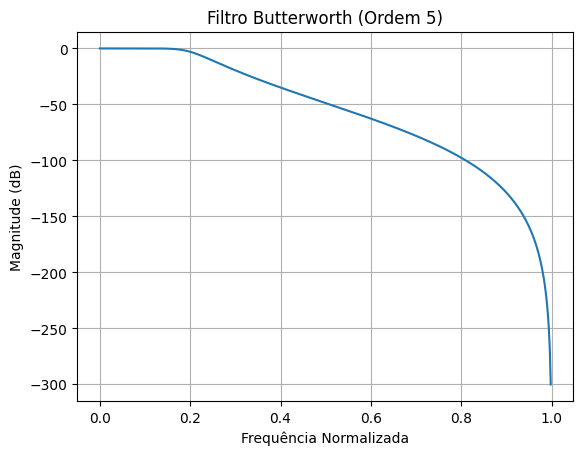

In [27]:
# Projeto de filtro Butterworth
N = 5       # Ordem
Wn = 0.2    # Frequência de corte normalizada
b, a = butter(N, Wn, btype='low')

# Resposta em frequência
w, h = freqz(b, a)
plt.plot(w/np.pi, 20*np.log10(abs(h)))
plt.title("Filtro Butterworth (Ordem 5)")
plt.xlabel("Frequência Normalizada")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.show()

### Chebyshev Tipo I

- Ripple na **banda de passagem**.
- Transição mais rápida que Butterworth.
- Utiliza polinômios de Chebyshev $T_N(x)$:

$$
|H_a(j\Omega)|^2 = \frac{1}{1 + \epsilon^2 T_N^2\left( \frac{\Omega}{\Omega_c} \right)}
$$

Onde:
- $T_N(x) = \cos(N \cos^{-1}(x))$ se $|x| \leq 1$
- $T_N(x) = \cosh(N \cosh^{-1}(x))$ se $|x| > 1$

---

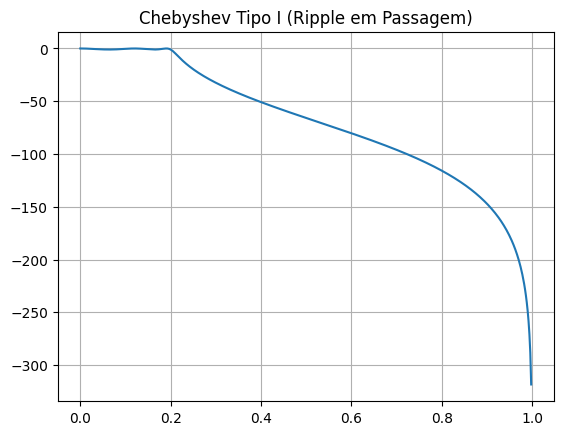

In [28]:
# Projeto com ripple de 1dB na banda de passagem
b, a = cheby1(N=5, rp=1, Wn=0.2, btype='low')
w, h = freqz(b, a)
plt.plot(w/np.pi, 20*np.log10(abs(h)))
plt.title("Chebyshev Tipo I (Ripple em Passagem)")
plt.grid()
plt.show()

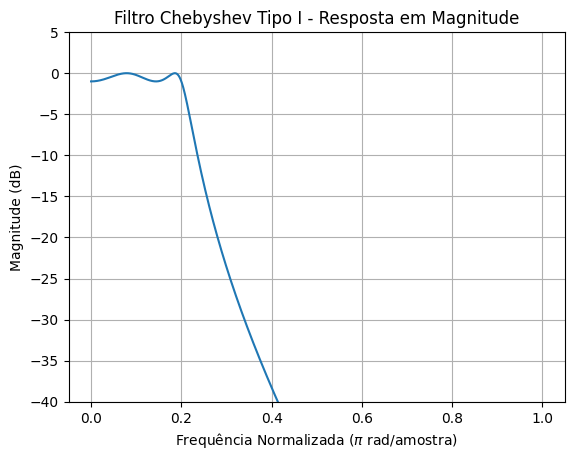

In [29]:
## Exemplo Computacional – Filtro Chebyshev Tipo I

wp = 0.2  # Normalizado (π = 1)
ws = 0.3
Rp = 1    # Ripple (dB)
As = 16   # Atenuação mínima (dB)

# Cálculo da ordem mínima do filtro
N, Wn = cheb1ord(wp, ws, Rp, As)
b, a = cheby1(N, Rp, Wn, btype='low')

# Resposta em frequência
w, h = freqz(b, a, worN=1024)
plt.plot(w/np.pi, 20 * np.log10(abs(h)))
plt.grid()
plt.title("Filtro Chebyshev Tipo I - Resposta em Magnitude")
plt.xlabel("Frequência Normalizada ($\pi$ rad/amostra)")
plt.ylabel("Magnitude (dB)")
plt.ylim(-40, 5)
plt.show()

### Elíptico (Cauer)

- Ripple **em ambas** as bandas.
- **Transição mais acentuada** entre passagem e rejeição.
- Utiliza funções elípticas de Jacobi (complexidade analítica maior).

---

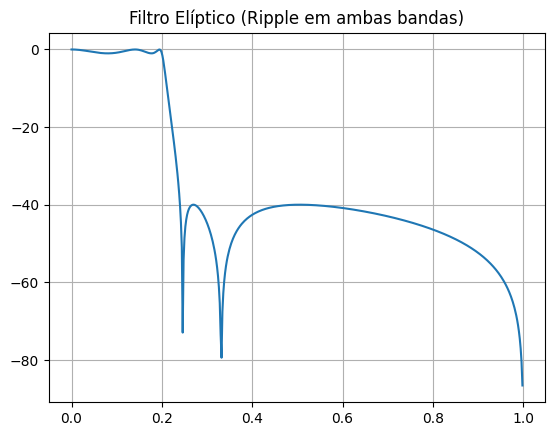

In [30]:
# Projeto com ripple em ambas as bandas
b, a = ellip(N=5, rp=1, rs=40, Wn=0.2, btype='low')
w, h = freqz(b, a)
plt.plot(w/np.pi, 20*np.log10(abs(h)))
plt.title("Filtro Elíptico (Ripple em ambas bandas)")
plt.grid()
plt.show()

## 8.3 Transformação Bilinear

Transforma a função de transferência de um filtro analógico $H_a(s)$ em sua versão digital $H(z)$ de maneira **estável e unívoca**.

### Fórmula:

$$
s = \frac{2}{T} \cdot \frac{1 - z^{-1}}{1 + z^{-1}}
$$

Essa substituição transforma o eixo imaginário de $s$ (frequência contínua) no **círculo unitário** no plano-z (frequência discreta).

#### Propriedades:
- **Estabilidade preservada**: região de convergência do sistema analógico mapeada dentro do círculo unitário.
- **Distorção não-linear de frequência**: compressão das altas frequências.
- Para compensar essa distorção, realiza-se uma **pré-distorção** (prewarping) nas frequências especificadas.

---

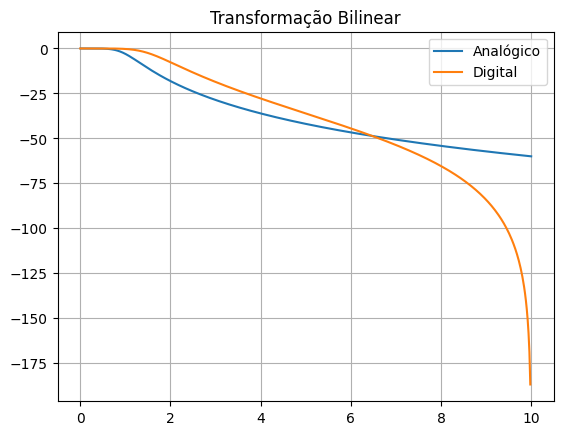

In [31]:
# Protótipo analógico (Butterworth)
b_a, a_a = butter(N=3, Wn=1, btype='low', analog=True)

# Transformação bilinear para digital

# Respostas
w_a, h_a = freqs(b_a, a_a)
w_d, h_d = freqz(b_d, a_d)

# Plot comparativo
plt.plot(w_a, 20*np.log10(abs(h_a)), label='Analógico')
plt.plot(w_d/np.pi*max(w_a), 20*np.log10(abs(h_d)), label='Digital')
plt.title("Transformação Bilinear")
plt.legend()
plt.grid()
plt.show()

## 8.4 Estrutura Recursiva e Realizações

Filtros IIR são implementados como equações de diferenças com feedback:

$$
y[n] = -\sum_{k=1}^{N} a_k y[n - k] + \sum_{k=0}^{M} b_k x[n - k]
$$

Isso leva à função de transferência:

$$
H(z) = \frac{Y(z)}{X(z)} = \frac{\sum_{k=0}^{M} b_k z^{-k}}{1 + \sum_{k=1}^{N} a_k z^{-k}}
$$

- Os coeficientes $a_k$ e $b_k$ são obtidos através dos algoritmos de projeto (e.g., `cheby1`, `butter`, `ellip`, etc.).

---


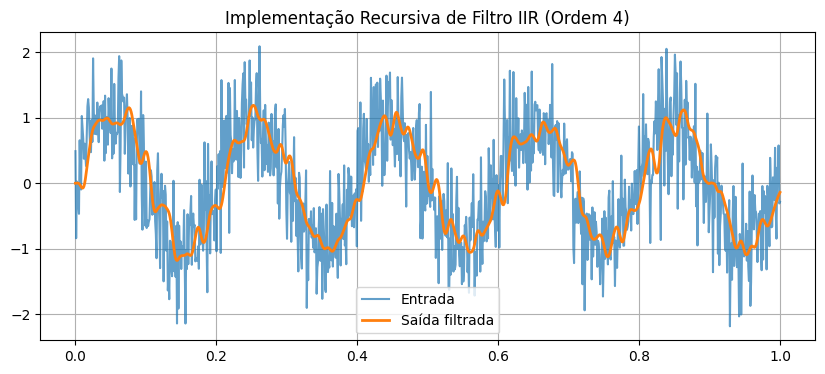

In [32]:
def iir_filter(x, b, a):
    y = np.zeros_like(x)
    M = len(b) - 1  # Ordem do filtro (parte feedforward)
    N = len(a) - 1  # Ordem do filtro (parte feedback)

    for n in range(len(x)):
        # Parte feedforward (b)
        feedforward = 0.0
        for k in range(0, M+1):
            if n - k >= 0:
                feedforward += b[k] * x[n - k]

        # Parte feedback (a)
        feedback = 0.0
        for k in range(1, N+1):
            if n - k >= 0:
                feedback += a[k] * y[n - k]

        y[n] = feedforward - feedback

    return y

# Teste com sinal senoidal + ruído
t = np.linspace(0, 1, 1000)
x = np.sin(2*np.pi*5*t) + 0.5*np.random.randn(1000)
b, a = butter(4, 0.1, btype='low')

# Normalizar os coeficientes pelo primeiro elemento de 'a'
a_normalized = a / a[0]
b_normalized = b / a[0]

y = iir_filter(x, b_normalized, a_normalized)

plt.figure(figsize=(10,4))
plt.plot(t, x, label='Entrada', alpha=0.7)
plt.plot(t, y, label='Saída filtrada', linewidth=2)
plt.legend()
plt.title("Implementação Recursiva de Filtro IIR (Ordem 4)")
plt.grid(True)
plt.show()

## Estabilidade

A estabilidade do sistema depende da **localização dos polos** no plano-z:

- Sistema estável ⟺ todos os polos estão **dentro do círculo unitário**: $|p_k| < 1$.
- A realimentação pode levar à instabilidade numérica, especialmente para ordens altas.

Por isso, é comum realizar a **decomposição em seções de segunda ordem** (biquads) para filtros de ordem elevada.

---

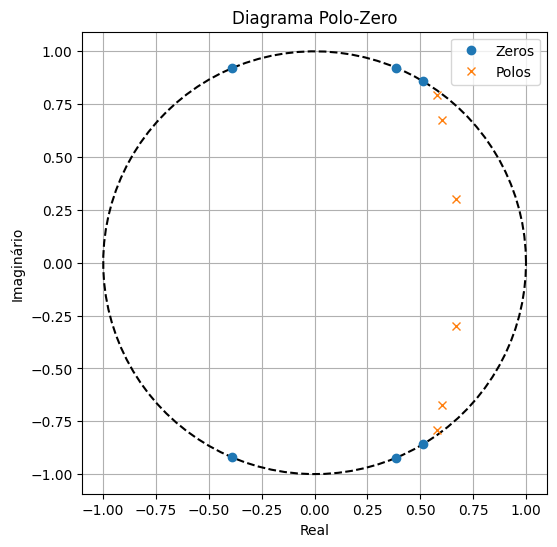

Todos os polos estão dentro do círculo unitário? True


In [33]:
b, a = ellip(6, 1, 40, 0.3, btype='low')

# Obter polos e zeros
z, p, k = tf2zpk(b, a)

# Plot no plano-Z
plt.figure(figsize=(6,6))
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--')  # Círculo unitário
plt.plot(np.real(z), np.imag(z), 'o', label='Zeros')
plt.plot(np.real(p), np.imag(p), 'x', label='Polos')
plt.title("Diagrama Polo-Zero")
plt.xlabel("Real")
plt.ylabel("Imaginário")
plt.grid()
plt.legend()
plt.axis('equal')
plt.show()

# Verificar se todos os polos estão dentro do círculo unitário
print("Todos os polos estão dentro do círculo unitário?", np.all(np.abs(p) < 1))

## Exemplo Completo: Projeto de Filtro IIR

/tmp/ipython-input-34-4119325435.py:30: UserWarning: The filter's denominator is extremely small at frequencies [3.135], around which a singularity may be present
  gd = group_delay((b, a), w)


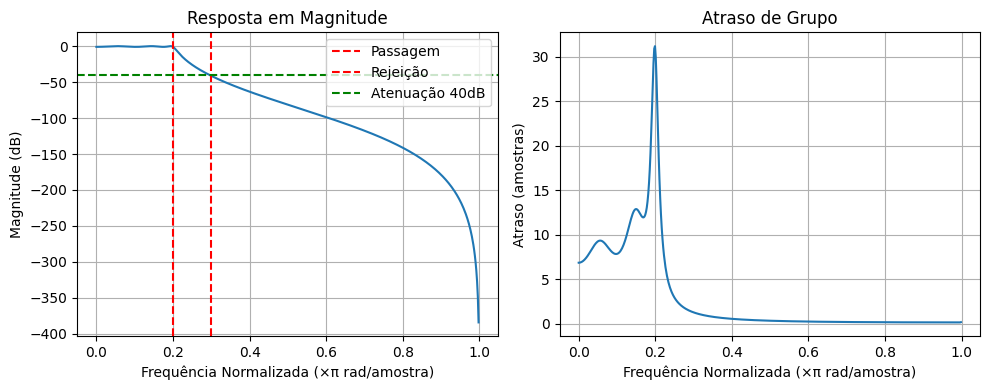

In [34]:
# Especificações
wp = 0.2  # Frequência de passagem
ws = 0.3  # Frequência de rejeição
Rp = 1    # Ripple na passagem (dB)
As = 40   # Atenuação na rejeição (dB)

# 1. Determinar ordem mínima
N, Wn = cheb1ord(wp, ws, Rp, As)

# 2. Projetar filtro
b, a = cheby1(N, Rp, Wn, btype='low')

# 3. Visualizar resposta
w, h = freqz(b, a)
plt.figure(figsize=(10,4))

# Resposta em magnitude
plt.subplot(121)
plt.plot(w/np.pi, 20*np.log10(abs(h)))
plt.axvline(wp, color='r', linestyle='--', label='Passagem')
plt.axvline(ws, color='r', linestyle='--', label='Rejeição')
plt.axhline(-As, color='g', linestyle='--', label=f'Atenuação {As}dB')
plt.title("Resposta em Magnitude")
plt.xlabel("Frequência Normalizada (×π rad/amostra)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.legend()

# Atraso de grupo - CORREÇÃO AQUI
gd = group_delay((b, a), w)
plt.subplot(122)
plt.plot(w/np.pi, gd[1])  # Pegamos apenas a segunda linha do retorno
plt.title("Atraso de Grupo")
plt.xlabel("Frequência Normalizada (×π rad/amostra)")
plt.ylabel("Atraso (amostras)")
plt.grid()

plt.tight_layout()
plt.show()

## Conclusão Final

- Filtros IIR são computacionalmente mais eficientes do que filtros FIR para a mesma especificação.
- A estabilidade depende da posição dos polos no plano-z.
- A transformação bilinear é um método seguro e determinístico para discretização de protótipos analógicos.
- As famílias de filtros (Butterworth, Chebyshev I/II, Elíptico) oferecem diferentes trade-offs entre ripple, transição e ordem.